In [12]:
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore


import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore

from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.neighbors import NearestNeighbors # type: ignore

In [14]:
# Clean data
df = pd.read_csv("../data/processed/data.csv")

In [15]:
# Dealing with missing values for now
df.rename(columns={'Product_price': 'revenue'}, inplace=True) 
df['Product_price'] = df['revenue'] + df['freight_value']

df['Product_weight_kg'] = df['Product_weight_kg'].fillna(df['Product_weight_kg'].mean())

df['distance_km'] = df['distance_km'].fillna(df['distance_km'].mean())

df['Product_size'] = df['Product_size'].fillna(df['Product_size'].mean())

df['customer_avg_score'] = df['customer_avg_score'].fillna(df['customer_avg_score'].mean())

df['No_photos'] = df['No_photos'].fillna(df['No_photos'].mean())

df['Product_price'] = df['Product_price'].fillna(df['Product_price'].mean())

df['freight_value'] = df['freight_value'].fillna(df['freight_value'].mean())

df['Rating'] = df['Rating'].round()

df['Product_category'] = df['Product_category'].fillna(df['Product_category'].mode()[0])

df['revenue'] = df['revenue'].fillna(df['revenue'].mean())

# Regression 
confounded

In [120]:
formula = 'Rating ~ is_delivery_late'
model = smf.ols(formula=formula, data=df)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                 1.365e+04
Date:                Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:39:48   Log-Likelihood:            -2.0222e+05
No. Observations:              119143   AIC:                         4.044e+05
Df Residuals:                  119141   BIC:                         4.045e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1318      0.004  

In [113]:
# Interpret
model = OrderedModel(df['Rating'], df['is_delivery_late'], distr='logit')
results = model.fit(method='bfgs')
print(results.summary())


Optimization terminated successfully.
         Current function value: 1.193346
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:            -1.4218e+05
Model:                   OrderedModel   AIC:                         2.844e+05
Method:            Maximum Likelihood   BIC:                         2.844e+05
Date:                Tue, 01 Oct 2024                                         
Time:                        14:31:46                                         
No. Observations:              119143                                         
Df Residuals:                  119138                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

\begin{align*}
    \text{logit}(P(Y \leq 1.0/2.0)) &= -2.1580 - 2.2398x_1 \\
    \text{logit}(P(Y \leq 2.0/3.0)) &= -1.1719 -2.2398x_1
\end{align*}


# Dowhy: 
PO & Graphical Causal Model

In [122]:
causal_graph = """digraph {
is_delivery_late;
Rating;
Product_category;
Product_size;
No_photos;
Product_price;
{{shipping_method}};
freight_value;
distance_km;
region;
season;
seller_hist_rating;
customer_avg_score;
{{customer_service}};
revenue;

Product_category_encoded -> is_delivery_late;
Product_category_encoded -> Rating;
Product_category_encoded -> Product_price;
Product_category_encoded -> Product_size;
Product_category_encoded -> No_photos;

Product_size -> {{shipping_method}};
Product_size -> freight_value;

No_photos -> Rating;

Product_price -> Rating;

{{shipping_method}} -> is_delivery_late;

freight_value -> is_delivery_late;
freight_value -> Rating;

distance_km -> season;
distance_km -> freight_value;
distance_km -> is_delivery_late;

region -> season;
region -> freight_value;
region -> is_delivery_late;


season -> is_delivery_late;
season -> Rating;

seller_hist_rating -> Product_price;

customer_avg_score -> seller_hist_rating;

{{customer_service}} -> Rating;

is_delivery_late -> Rating;
is_delivery_late -> {{customer_service}};
is_delivery_late -> revenue;
Product_price -> revenue
}"""

In [16]:
# Create a new directed graph
G = nx.DiGraph()


# Add nodes
nodes = [
'Rating',
'Product_category',
'Product_size',
'No_photos',
'Product_price',
# 'shipping_method',
'freight_value',
'distance_km',
'region',
'season',
'seller_hist_rating',
'customer_avg_score',
# 'customer_service',
'revenue'
]
G.add_nodes_from(nodes)


# Add edges (relationships)
edges = [
    ('Product_category_encoded', 'is_delivery_late'),
    ('Product_category_encoded', 'Rating'),
    ('Product_category_encoded', 'Product_price'),
    ('Product_category_encoded', 'Product_size'),
    ('Product_category_encoded', 'No_photos'),

    # ('Product_size', 'shipping_method'),
    ('Product_size', 'freight_value'),

    ('No_photos', 'Rating'),

    ('Product_price', 'Rating'),

    # ('shipping_method', 'is_delivery_late'),

    ('freight_value', 'is_delivery_late'),
    ('freight_value', 'Rating'),

    ('distance_km', 'season'),
    ('distance_km', 'freight_value'),
    ('distance_km', 'is_delivery_late'),

    ('region', 'season'),
    ('region', 'freight_value'),
    ('region', 'is_delivery_late'),

    ('season', 'is_delivery_late'),
    ('season', 'Rating'),

    ('seller_hist_rating', 'Product_price'),

    ('customer_avg_score', 'seller_hist_rating'),

    # ('customer_service', 'Rating'),

    ('is_delivery_late', 'Rating'),
    # ('is_delivery_late', 'customer_service'),
    ('is_delivery_late', 'revenue'),

    ('Product_price', 'revenue')
]

G.add_edges_from(edges)
# nx.set_node_attributes(G, {'customer_service': {'measured': False}, 'shipping_method': {'measured': False}})

In [123]:
methods_dict = {
    "Propensity Score Matching": "backdoor.propensity_score_matching",
    "Propensity Score Stratification": "backdoor.propensity_score_stratification",
    "Propensity Score-based Inverse Weighting": "backdoor.propensity_score_weighting",
    "Linear Regression": "backdoor.linear_regression",
    "Generalized Linear Models": "backdoor.generalized_linear_model",
    "Instrumental Variables": "iv.instrumental_variable",
    "Regression Discontinuity": "iv.regression_discontinuity",
    "Two Stage Regression": "frontdoor.two_stage_regression"
}


In [124]:
# Causal Graph params
treatment='is_delivery_late' 
outcome='Rating'

# Estimation params
method_name_estimation = 'backdoor.propensity_score_weighting'
target_units = 'ate'


# Causal Model
model = CausalModel(data=df, graph=causal_graph.replace("\n", " "), treatment=treatment, outcome=outcome)

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimation
causal_estimate = model.estimate_effect(identified_estimand, method_name=method_name_estimation, target_units=target_units)
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                  
───────────────────(E[Rating|Product_category_encoded,season,freight_value])
d[is_delivery_late]                                                         
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,Product_category_encoded,season,freight_value,U) = P(Rating|is_delivery_late,Product_category_encoded,season,freight_value)

## Realized estimand
b: Rating~is_delivery_late+Product_category_encoded+season+freight_value
Target units: ate

## Estimate
Mean value: -1.817011277817044



In [125]:
# Refutation params
method_name='random_common_cause'
placebo_type='permute'

refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name=method_name,
                                           placebo_type=placebo_type, num_simulations=20, show_progress_bar=True) 

print(refutation)

Refuting Estimates: 100%|██████████| 20/20 [00:01<00:00, 16.70it/s]

Refute: Add a random common cause
Estimated effect:-1.817011277817044
New effect:-1.8170112778170442
p value:0.15865525393145707



# Graphical Causal Model

In [20]:
causal_model = gcm.StructuralCausalModel(G)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, df)
gcm.fit(causal_model, df)

Fitting causal mechanism of node is_delivery_late: 100%|██████████| 14/14 [00:06<00:00,  2.16it/s]       


In [21]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [22]:
gcm.average_causal_effect(causal_model,
                         'Rating',
                         interventions_alternative={'is_delivery_late': lambda x: 1},
                         interventions_reference={'is_delivery_late': lambda x: 0},
                         num_samples_to_draw=1000)

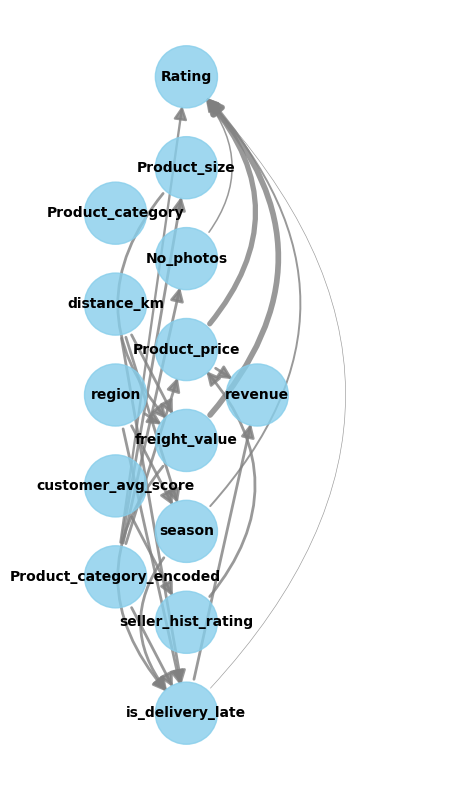

In [23]:
arrow_strengths_mpg = gcm.arrow_strength(causal_model, target_node='Rating')
gcm.util.plot(causal_model.graph, causal_strengths=arrow_strengths_mpg)

In [25]:
iccs_rating = gcm.intrinsic_causal_influence(causal_model, target_node='Rating')

Estimating Shapley Values. Average change of Shapley values in run 54 (270 evaluated permutations): 1.0941049217872987%: 100%|██████████| 1/1 [26:02<00:00, 1562.90s/it]


In [26]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

In [31]:
convert_to_percentage(iccs_rating)

{'distance_km': np.float64(0.12132982465493491),
 'region': np.float64(0.0014507931067662756),
 'customer_avg_score': np.float64(0.01139904627024492),
 'Product_category_encoded': np.float64(0.06309511455135451),
 'season': np.float64(0.02514387785938051),
 'seller_hist_rating': np.float64(0.03756482255832838),
 'Product_size': np.float64(0.008434556866027756),
 'No_photos': np.float64(0.046316410847175665),
 'Product_price': np.float64(0.2944791604869846),
 'freight_value': np.float64(0.3459937166257896),
 'is_delivery_late': np.float64(1.6061671880053003e-15),
 'Rating': np.float64(99.04479267617302)}

In [37]:
list(convert_to_percentage(iccs_rating).keys())[:-1]

['distance_km',
 'region',
 'customer_avg_score',
 'Product_category_encoded',
 'season',
 'seller_hist_rating',
 'Product_size',
 'No_photos',
 'Product_price',
 'freight_value',
 'is_delivery_late',
 'Rating']

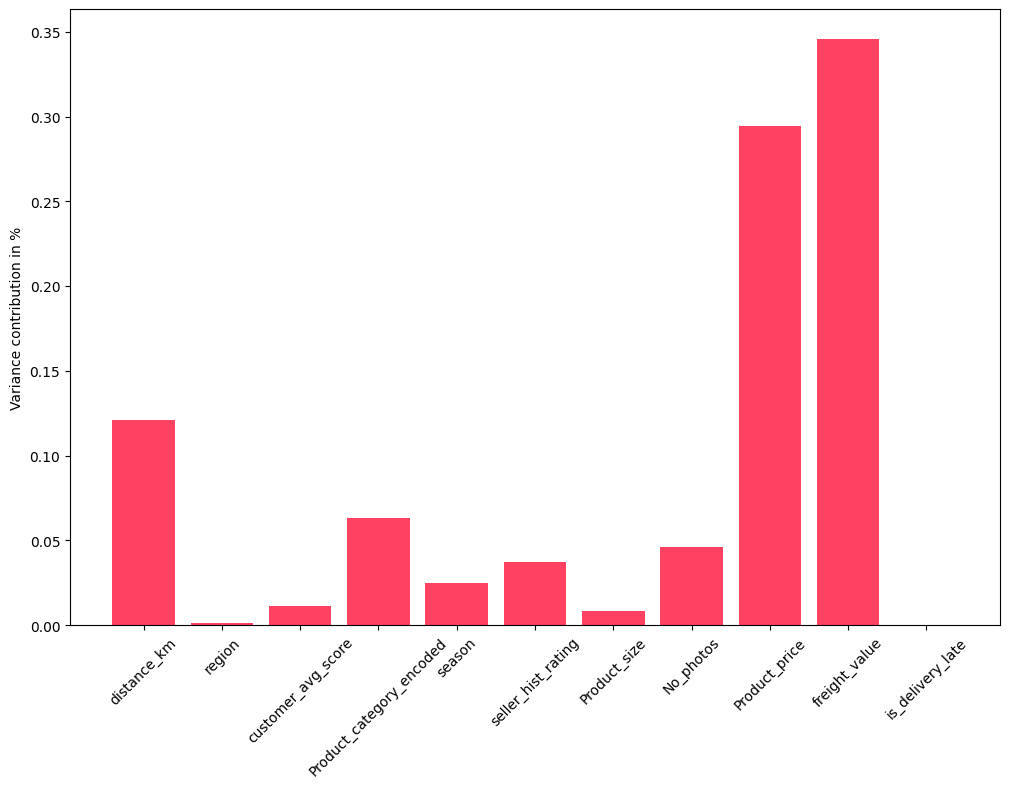

In [50]:
plt.figure(figsize=(12,8))
plt.bar(list(convert_to_percentage(iccs_rating).keys())[:-1], list(convert_to_percentage(iccs_rating).values())[:-1], color='#FF4162')
plt.ylabel("Variance contribution in %")
plt.xticks(rotation=45)
plt.show()

----
-----
-----

# Refutation


Refutation methods provide tests that every correct estimator should pass. 
So if an estimator fails the refutation test (p-value is <0.05), 
then it mean that there is some problem with the estimator


Refutation methods cannot verify that the estimate is correct but they can reject
it if it violates certain expected behavior.

The below refutation tests are based on either:
- 1. **Invariant transformations:** changes in the data that should not change the estimate. Any estimator whose result varies significantly between the original data and the modified data fails the test

    - a. Random Common Cause
    - b. Data Subset

- 2. **Nullifying transformations:** after the data change, the causal true estimate is zero. Any estimator whose result varies significantly from zero on the new data fails the test

    - a. Placebo Treatment


In [202]:
method_name='random_common_cause'
placebo_type='permute'
refutation = causal_model.refute_causal_estimate(model=model,
                                     identified_estimand=identified_estimand, 
                                     causal_estimate=causal_estimate,
                                     method_name=method_name,
                                     placebo_type=placebo_type)
print(refutation)

Refuting Estimates: 100%|██████████| 20/20 [00:01<00:00, 14.46it/s]

Refute: Add a random common cause
Estimated effect:-1.8298024128527417
New effect:-1.829802412852742
p value:0.15865525393145707



In [203]:
method_name='placebo_treatment_refuter'
placebo_type='permute'
refutation = causal_model.refute_causal_estimate(model=model,
                                     identified_estimand=identified_estimand, 
                                     causal_estimate=causal_estimate,
                                     method_name=method_name,
                                     placebo_type=placebo_type)
print(refutation)

Refuting Estimates: 100%|██████████| 20/20 [00:01<00:00, 15.06it/s]

Refute: Use a Placebo Treatment
Estimated effect:-1.8298024128527417
New effect:0.031137240324917936
p value:0.005948113528832562



In [141]:
method_name='data_subset_refuter'
placebo_type='permute'
refutation = causal_model.refute_causal_estimate(model=model,
                                     identified_estimand=identified_estimand, 
                                     causal_estimate=causal_estimate,
                                     method_name=method_name,
                                     placebo_type=placebo_type,
                                     subset_fraction=0.6)
print(refutation)

Refuting Estimates: 100%|██████████| 20/20 [00:00<00:00, 22.96it/s]

Refute: Use a subset of data
Estimated effect:-1.8289235868800984
New effect:-1.8274443903777875
p value:0.45706674665010255



### Sensitivity Test

This refutation does not return a p-value. Instead, it provides a sensitivity test on how quickly the estimate changes if the identifying assumptions are not valid. Specifically, it checks sensitivity to violation of the backdoor assumption: that all common causes are observed.

To do so, it creates a new dataset with an additional common cause between treatment and outcome. To capture the effect of the common cause, the method takes as input the strength of common cause's effects, it changes the treatment and outcome values and then reruns the estimator. The hope is that the new estimate does not change drastically with a small effect of the unobserved common cause, indicating robustness to any unobserved confounding.

**Another equivalent way of interpreting this procedure is to assume that there was already unobserved confounding present in the input data**. The change in treatment and outcome values removes the effect of whatever unobserved common cause was present  in the original data. Then rerunning the estimator on this modified data provides the correct identified estimate and we hope that the difference between the new estimate and the original estimate is not too high, for some bounded value of the unobserved common cause's effect/

In [142]:
confounders_effect_on_treatment="binary_flip"
confounders_effect_on_outcome="linear"
effect_strength_on_treatment=0.01
effect_strength_on_outcome=0.02

sensitivity = causal_model.run_sentitivity_analysis(model=model,
                                      identified_estimand=identified_estimand,
                                      causal_estimate=causal_estimate,
                                      confounders_effect_on_treatment=confounders_effect_on_treatment,
                                      confounders_effect_on_outcome=confounders_effect_on_outcome,
                                      effect_strength_on_treatment=effect_strength_on_treatment,
                                      effect_strength_on_outcome=effect_strength_on_outcome)
print(sensitivity)

Refute: Add an Unobserved Common Cause
Estimated effect:-1.8289235868800984
New effect:-1.5926312064080395



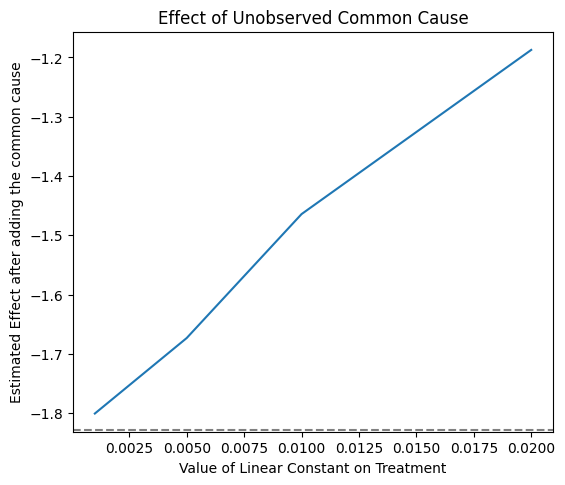

Refute: Add an Unobserved Common Cause
Estimated effect:-1.8289235868800984
New effect:(np.float64(-1.8005516042936973), np.float64(-1.1873708061877415))



In [143]:
confounders_effect_on_treatment="binary_flip"
confounders_effect_on_outcome="linear"
effect_strength_on_treatment=np.array([0.001, 0.005, 0.01, 0.02])
effect_strength_on_outcome=0.01


sensitivity_range = causal_model.run_sentitivity_analysis(model=model,
                                      identified_estimand=identified_estimand,
                                      causal_estimate=causal_estimate,
                                      confounders_effect_on_treatment=confounders_effect_on_treatment,
                                      confounders_effect_on_outcome=confounders_effect_on_outcome,
                                      effect_strength_on_treatment=effect_strength_on_treatment,
                                      effect_strength_on_outcome=effect_strength_on_outcome)
print(sensitivity_range)

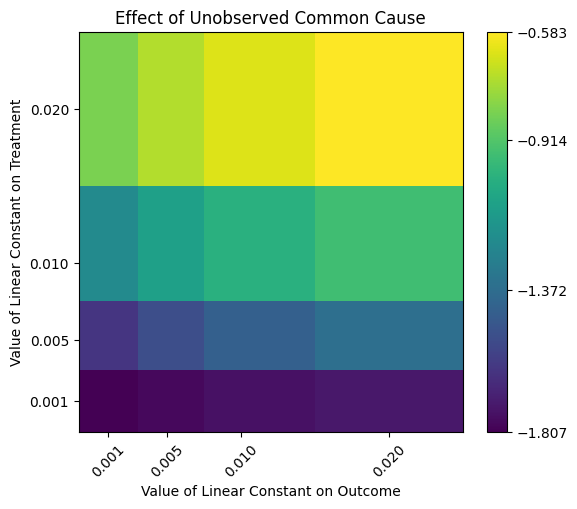

Refute: Add an Unobserved Common Cause
Estimated effect:-1.8289235868800984
New effect:(np.float64(-1.80692154486412), np.float64(-0.582916579666545))



In [144]:
confounders_effect_on_treatment="binary_flip"
confounders_effect_on_outcome="linear"
effect_strength_on_treatment=np.array([0.001, 0.005, 0.01, 0.02])
effect_strength_on_outcome=[0.001, 0.005, 0.01,0.02]

sensitivity_range = causal_model.run_sentitivity_analysis(model=model,
                                      identified_estimand=identified_estimand,
                                      causal_estimate=causal_estimate,
                                      confounders_effect_on_treatment=confounders_effect_on_treatment,
                                      confounders_effect_on_outcome=confounders_effect_on_outcome,
                                      effect_strength_on_treatment=effect_strength_on_treatment,
                                      effect_strength_on_outcome=effect_strength_on_outcome)
print(sensitivity_range)

/Users/juanherrera/Desktop/causal-attribution-analysis/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/juanherrera/Desktop/causal-attribution-analysis/venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/juanherrera/Desktop/causal-attribution-analysis/venv/lib/python3.9/site-packages/dowhy/causal_refuters/add_unobserved_common_cause.py:304: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

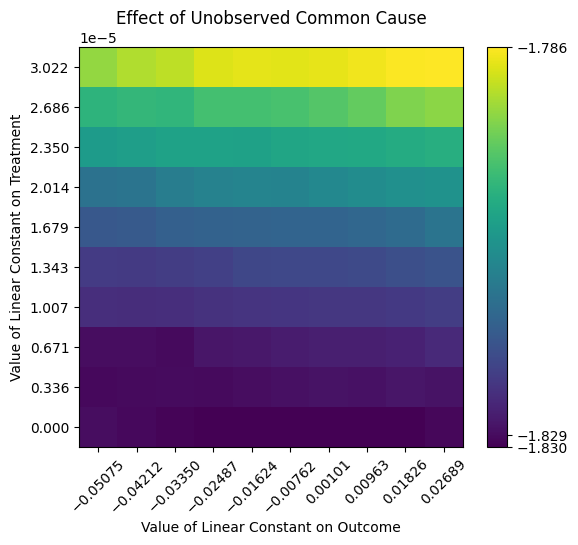

Refute: Add an Unobserved Common Cause
Estimated effect:-1.8289235868800984
New effect:(np.float64(-1.8302274423193348), np.float64(-1.7856957612995252))



In [145]:
confounders_effect_on_treatment="binary_flip"
confounders_effect_on_outcome="linear"

sensitivity_range = causal_model.run_sentitivity_analysis(model=model,
                                      identified_estimand=identified_estimand,
                                      causal_estimate=causal_estimate,
                                      confounders_effect_on_treatment=confounders_effect_on_treatment,
                                      confounders_effect_on_outcome=confounders_effect_on_outcome)
print(sensitivity_range)

In [ ]:
# target_units = 'att'
# for m in methods_dict.keys():

#     if methods_dict[m] == 'backdoor.generalized_linear_model':
#         pass

#     elif 'backdoor' in methods_dict[m]:
#         method_name = methods_dict[m]
#         causal_estimate = causal_model.estimate_causal_effect(model=model, identified_estimand=identified_estimand, method_name=method_name, target_units=target_units)

#     print(method_name, causal_estimate.value)
#     print()

----
# Manually Done

**Propensity Score Distancen**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors


lr = LogisticRegression()
lr.fit(df[['season', 'freight_value', 'Product_category_encoded']], df['is_delivery_late'])
lr.predict_proba(df[['season', 'freight_value', 'Product_category_encoded']])[:,1]
df['propensity_score'] = lr.predict_proba(df[['season', 'freight_value', 'Product_category_encoded']])[:,1]

# Split into treated and control groups
treated = df[df['is_delivery_late'] == 1]
control = df[df['is_delivery_late'] == 0]

neighbors = []
ate_lst = []

for i in range(1,30,2):

    # Fit nearest neighbors model
    nbrs = NearestNeighbors(n_neighbors=i).fit(control[['propensity_score']])

    # Find matches
    distances, indices = nbrs.kneighbors(treated[['propensity_score']])
    matched_control = control.iloc[indices.flatten()]

    # Combine matched treated and control groups
    matched_data = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)])

    ate = matched_data[matched_data['is_delivery_late'] == 0]['Rating'].mean() - matched_data[matched_data['is_delivery_late'] == 1]['Rating'].mean()

    neighbors.append(i)
    ate_lst.append(ate)


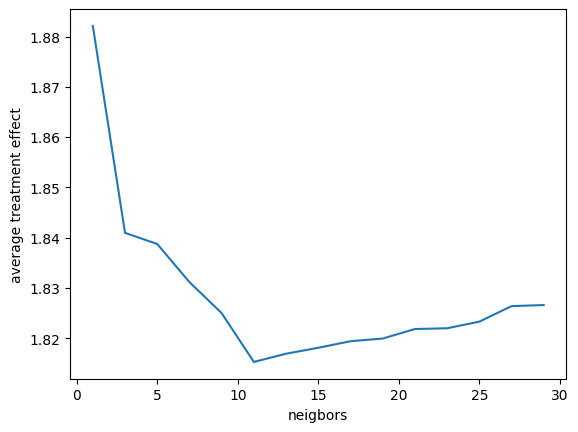

In [559]:
plt.plot(neighbors, ate_lst)

plt.xlabel("neigbors")
plt.ylabel("average treatment effect");

**propensity score weighting**

In [587]:
df['weight'] = 0  # Initialize weight column
df.loc[df['is_delivery_late'] == 1, 'weight'] = 1 / df['propensity_score']
df.loc[df['is_delivery_late'] == 0, 'weight'] = 1 / (1 - df['propensity_score'])

weighted_mean_treated = (df[df['is_delivery_late'] == 1]['Rating'] * df[df['is_delivery_late'] == 1]['weight']).sum() / df[df['is_delivery_late'] == 1]['weight'].sum()
weighted_mean_control = (df[df['is_delivery_late'] == 0]['Rating'] * df[df['is_delivery_late'] == 0]['weight']).sum() / df[df['is_delivery_late'] == 0]['weight'].sum()

ATE_ipw = weighted_mean_treated - weighted_mean_control
ATE_ipw


/var/folders/7s/18428v6x0c9g1ltv9g71gm1h0000gn/T/ipykernel_83593/2181768210.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.35727431 13.69337125 13.98192253 ... 14.83264187 10.49031108
 10.68591127]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['is_delivery_late'] == 1, 'weight'] = 1 / df['propensity_score']


**Exact Matching**

In [9]:
exact_match_lst = []

for i in treated['propensity_score']:
    index_exact_match = control[abs(control['propensity_score'] - i) < 0.001].index

    for y in index_exact_match:
        exact_match_lst.append(y)



----
Other

In [44]:
# class MakeModel:

#     def __init__(self):
#         pass

#     def make_causal_model(self, data, causal_graph, treatment, outcome):
#         model = CausalModel(data=data, graph=causal_graph.replace("\n", " "), treatment=treatment, outcome=outcome)
#         return model

#     def identify_causal_effect(self, model, method=''):
#         if method != '':
#             identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method=method)
#         else:
#             identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
#         return identified_estimand

#     def estimate_causal_effect(self, model, identified_estimand, target_units, method_name, glm_family=''):
#         if glm_family != '':
#             causal_estimate = model.estimate_effect(identified_estimand, method_name=method_name, 
#                                                     target_units=target_units,glm_family=glm_family)
#         else:
#             causal_estimate = model.estimate_effect(identified_estimand, method_name=method_name, target_units=target_units)
#         return causal_estimate
        
#     def refute_causal_estimate(self, model, identified_estimand, causal_estimate, method_name, placebo_type, subset_fraction=''):

#         if subset_fraction != '':
#             refutation = model.refute_estimate(identified_estimand, 
#                                                causal_estimate, 
#                                                method_name=method_name,
#                                                placebo_type=placebo_type, 
#                                                num_simulations=20, 
#                                                show_progress_bar=True,
#                                                subset_fraction=subset_fraction)
#         else:
#             refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name=method_name,
#                                            placebo_type=placebo_type, num_simulations=20, show_progress_bar=True)        
#         return refutation
    
#     def run_sentitivity_analysis(self, model, identified_estimand, causal_estimate, 
#                                  confounders_effect_on_treatment, confounders_effect_on_outcome,
#                                   effect_strength_on_treatment='', effect_strength_on_outcome=''):
        
#         if type(effect_strength_on_treatment) != str and type(effect_strength_on_outcome) != str:
#             res_unobserved=model.refute_estimate(identified_estimand, 
#                                                 causal_estimate, 
#                                                 method_name="add_unobserved_common_cause",
#                                                 confounders_effect_on_treatment=confounders_effect_on_treatment, 
#                                                 confounders_effect_on_outcome=confounders_effect_on_outcome,
#                                                 effect_strength_on_treatment=effect_strength_on_treatment, 
#                                                 effect_strength_on_outcome=effect_strength_on_outcome)
#         else:
#             res_unobserved=model.refute_estimate(identified_estimand, 
#                                     causal_estimate, 
#                                     method_name="add_unobserved_common_cause",
#                                     confounders_effect_on_treatment=confounders_effect_on_treatment, 
#                                     confounders_effect_on_outcome=confounders_effect_on_outcome)

#         return res_unobserved
        

'class MakeModel:\n\n    def __init__(self):\n        pass\n\n    def make_causal_model(self, data, causal_graph, treatment, outcome):\n        model = CausalModel(data=data, graph=causal_graph.replace("\n", " "), treatment=treatment, outcome=outcome)\n        return model\n\n    def identify_causal_effect(self, model, method=\'\'):\n        if method != \'\':\n            identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method=method)\n        else:\n            identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)\n        return identified_estimand\n\n    def estimate_causal_effect(self, model, identified_estimand, target_units, method_name, glm_family=\'\'):\n        if glm_family != \'\':\n            causal_estimate = model.estimate_effect(identified_estimand, method_name=method_name, \n                                                    target_units=target_units,glm_family=glm_family)\n        else:\n            causal_estimat